<a href="https://colab.research.google.com/github/VishnuPy/MyPython/blob/master/XGBoost_parameterTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%ls

Found GPU at: /device:GPU:0
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
'My Drive'/


In [0]:
%cd 'My Drive/MyLearning/MLDLAIPython/Data/TextData/'
%ls

/gdrive/My Drive/MyLearning/MLDLAIPython/Data/TextData
Adult.csv                          mnist_submission.csv
Airline_Tweets.csv                 MNISTtest.csv
APPL_Stock_Data_1980thru2019.xlsx  MNIST_train.csv
APPL_Stock_Data_2009thru2019.xlsx  NaN_Predict_test.csv
APPL_Stock_Test_2019_Apr_Jun.xlsx  NaN_Predict_train.csv
bank-additional-full.csv           neg/
bank-additional-full_prj.csv       nyay.csv
Bank_Customer_Churn_Modelling.csv  Portuguese_Bank_Phone_calls.csv
BankLoan_test.csv                  pos/
BankLoan_train.csv                 purchase_fre_job.png
Bigmart_SampleSubmission.csv       pur_dayofweek_bar.png
Bigmart_SampleSubmission.gsheet    pur_fre_month_bar.png
Bigmart_Test.csv                   pur_fre_pout_bar.png
Bigmart_Train.csv                  small_tree.dot
Breast_Cancer_Knn_ImPrj.csv        small_tree.png
breast-cancer-wisconsin-data.csv   submit_file.csv
Cancer.csv                         submit_file.gsheet
caravan-insurance-challenge.csv    temps.csv
count_plo

In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6224754770009895
GPU (s):
0.19054672999845934
GPU speedup over CPU: 19x


In [0]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score   #Perforing grid search and Cross Validation Score

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('train_modified.csv')
target = 'Disbursed'
IDcol = 'ID'

In [0]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds)   #, show_progress=False)
        
    alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
#    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

<font color=red size=5>
  General Approach for Parameter Tuning
We will use an approach similar to that of GBM here. The various steps to be performed are:
<br></font>
<font color=brown size=4>
1. Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
  <br>
2. Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
  <br>
3. Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
  <br>
4. Lower the learning rate and decide the optimal parameters
  <br> 

<font color=red size=5>
Step 1: Fix learning rate and number of estimators for tuning tree-based parameters
<br> </font>
<font color=brown size=4>
1.max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points. <br>
2. min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.<br>
3. gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later. <br>
4. subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9. <br>
5. scale_pos_weight = 1: Because of high class imbalance.


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.899283


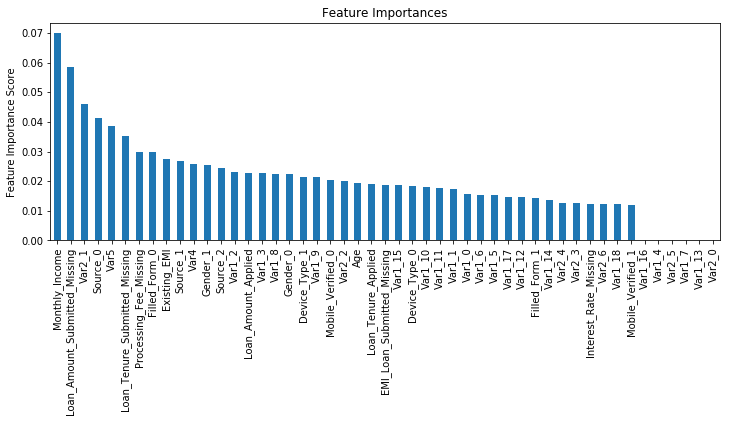

In [0]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


modelfit(xgb1, train, predictors)

#feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#xgb1.booster().get_fscore()

<font color=blue size = 6 >
Step 2: Tune max_depth and min_child_weight

In [0]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.score, gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


(<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score='raise-deprecating',
              estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                      colsample_bylevel=1, colsample_bynode=1,
                                      colsample_bytree=0.8, gamma=0,
                                      learning_rate=0.1, max_delta_step=0,
                                      max_depth=5, min_child_weight=1,
                                      missing=None, n_estimators=140, n_jobs=1,
                                      nthread=4, objective='binary:logistic',
                                      random_state=0, reg_alpha=0, reg_lambda=1,
                                      scale_pos_weight=1, seed=27, silent=None,
                                      subsample=0.8, verbosity=1),
              iid=False, n_jobs=-1,
              param_grid={'max_depth': range(3, 10, 2),
                          'min_child_weight': range(1, 6, 2)},
    

In [0]:
gsearch1.cv_results_

{'mean_fit_time': array([18.6157413 , 18.60938354, 18.50003448, 29.19397502, 29.10255098,
        28.9643312 , 40.50605001, 40.00362654, 39.5657763 , 52.10725527,
        50.70030627, 47.52455239]),
 'mean_score_time': array([0.11553659, 0.10402093, 0.11159444, 0.15602069, 0.14892025,
        0.15452642, 0.23972821, 0.23304076, 0.22851796, 0.29972134,
        0.27758827, 0.25109839]),
 'mean_test_score': array([0.83855951, 0.83719232, 0.83840884, 0.84039019, 0.83946644,
        0.8406519 , 0.83596044, 0.83606722, 0.83644527, 0.82868414,
        0.83128045, 0.83097796]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
              mask=[False, False, False, False, False, False, False, False,
           

In [0]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


({'mean_fit_time': array([47.23610487, 46.9751554 , 47.74043598, 58.6022851 , 58.61847339,
         57.10043468, 68.64976525, 69.93881559, 60.08718028]),
  'mean_score_time': array([0.35749731, 0.29504266, 0.33397388, 0.36897206, 0.34147649,
         0.35652099, 0.42317944, 0.42256937, 0.29136915]),
  'mean_test_score': array([0.84110102, 0.83997923, 0.83943053, 0.84083405, 0.8406519 ,
         0.83948369, 0.83990606, 0.83810419, 0.83856804]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 4, 'min_child_weight': 4},
   {'max_depth': 4, 'min_child_weig

In [0]:
#we got 6 as optimum value for min_child_weight but we haven’t tried values more than 6. We can do that as follow:

param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=2,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'min_child_weight': [6, 8, 10, 12]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', ve


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.874137


({'mean_fit_time': array([47.85882421, 47.68460793, 46.47036119, 44.49716311]),
  'mean_score_time': array([0.30226316, 0.27518196, 0.26131234, 0.19600544]),
  'mean_test_score': array([0.83943053, 0.83947412, 0.84037456, 0.84075997]),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'rank_test_score': array([4, 3, 2, 1], dtype=int32),
  'split0_test_score': array([0.83112251, 0.83240473, 0.83245481, 0.83381878]),
  'split1_test_score': array([0.83244875, 0.83106122, 0.83270988, 0.83423667]),
  'split2_test_score': array([0.84664743, 0.84457643, 0.84729036, 0.8473872 ]),
  'split3_test_score': array([0.84566993, 0.84604736, 0.84880618, 0.84840258]),
  'split4_test_score': array([0.84126402, 0.84328085, 0.84061156, 0.83995463]),
  'std_fit_time': 

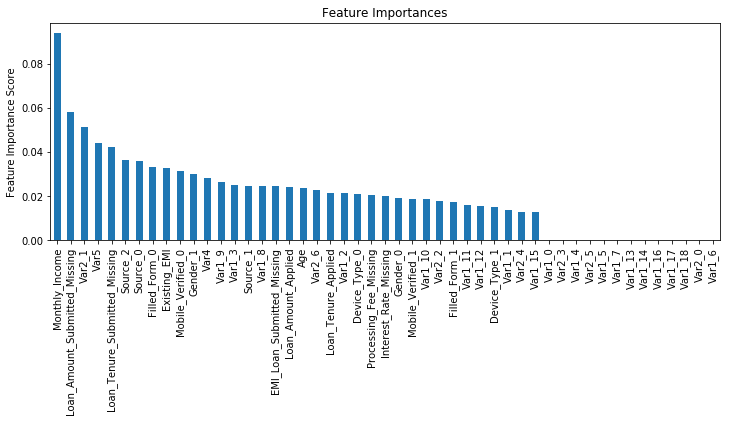

In [0]:
modelfit(gsearch2b.best_estimator_, train, predictors)
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

<font color=red size=6>
  Step 3: Tune gamma
  </font>
  <font color=red size=4>
Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here. You can go into more precise values as.

In [0]:
# best params for max_Depth and min_child_weight are 4 and 4 respectively. This is my findings above. 
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


({'mean_fit_time': array([47.49727011, 47.2707448 , 48.07068272, 47.39015265, 40.07052107]),
  'mean_score_time': array([0.27556677, 0.29387054, 0.32614532, 0.32801895, 0.23794079]),
  'mean_test_score': array([0.84110102, 0.84036035, 0.84031526, 0.84122602, 0.84118578]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'rank_test_score': array([3, 4, 5, 1, 2], dtype=int32),
  'split0_test_score': array([0.83215149, 0.83173166, 0.83263534, 0.83289281, 0.83247105]),
  'split1_test_score': array([0.83380838, 0.83124576, 0.82956383, 0.83183605, 0.83257749]),
  'split2_test_score': array([0.84810113, 0.84752407, 0.84802624, 0.84749422, 0.84808912]),
  'split3_test_score': array([0.84763098, 0.84826002, 0.84781889, 0.84876727, 0.84917063]),
  'split4_test_score':

In [0]:
# best params for max_Depth and min_child_weight are 4 and 6 respectively. This is the example i am trying on analyticsvidya
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


({'mean_fit_time': array([46.67189741, 47.48925209, 46.80876336, 47.39302464, 41.41357579]),
  'mean_score_time': array([0.32437773, 0.30959983, 0.27833805, 0.32396579, 0.24461002]),
  'mean_test_score': array([0.83943053, 0.84018797, 0.83977288, 0.83984317, 0.84050145]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'rank_test_score': array([5, 2, 4, 3, 1], dtype=int32),
  'split0_test_score': array([0.83112251, 0.83245241, 0.83292083, 0.83066175, 0.83183159]),
  'split1_test_score': array([0.83244875, 0.83311908, 0.83028549, 0.83439204, 0.8336466 ]),
  'split2_test_score': array([0.84664743, 0.84747993, 0.84643054, 0.84642859, 0.84728807]),
  'split3_test_score': array([0.84566993, 0.84788523, 0.84795571, 0.84579815, 0.84801919]),
  'split4_test_score':


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.889393


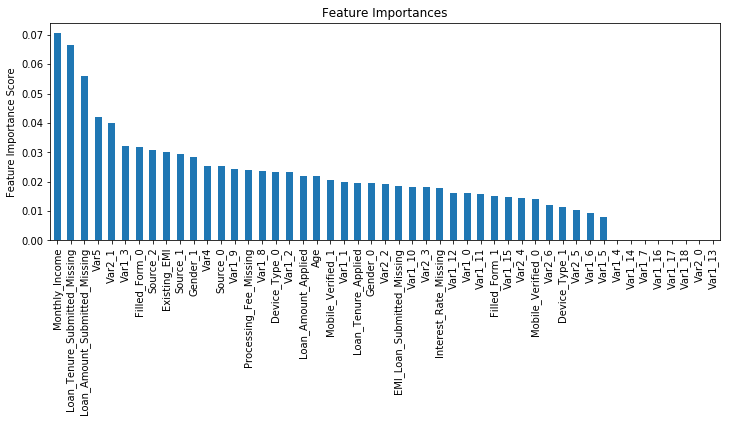

In [0]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=4,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

<font color=brown size = 6>
  Best Parameters
  </font> <br>
<font color=brown size = 4>
max_depth: 4
<br>
min_child_weight: 6
<br>
gamma: 0
  <br>
  </font>
  <font color=green size=7>
    Step 4: Tune subsample and colsample_bytree
    <br></font>
  <font color=blue size=4>
The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [0]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


({'mean_fit_time': array([49.95533524, 50.69778557, 49.17524104, 46.57688589, 58.36243405,
         56.34013071, 52.66266804, 51.88854642, 63.5693933 , 61.53249164,
         58.64327011, 56.63463016, 67.88152819, 66.60988498, 64.47620034,
         61.32991128]),
  'mean_score_time': array([0.31682539, 0.36812005, 0.35237112, 0.36269374, 0.40606256,
         0.34689074, 0.34520073, 0.40024915, 0.36819401, 0.37486248,
         0.3380897 , 0.37756791, 0.39696684, 0.37049079, 0.36098828,
         0.28129668]),
  'mean_test_score': array([0.83928837, 0.8395713 , 0.83895086, 0.8404917 , 0.83865809,
         0.83924369, 0.83996767, 0.84000309, 0.83843279, 0.84027534,
         0.8410694 , 0.84078762, 0.83904113, 0.83837859, 0.8403183 ,
         0.84023111]),
  'param_colsample_bytree': masked_array(data=[0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8,
                     0.8, 0.9, 0.9, 0.9, 0.9],
               mask=[False, False, False, False, False, False, False, False,
             

<font color=brown size=5> 
Here, we found  **0.8 as the optimum value** for both subsample and colsample_bytree. Now we should try values in 0.05 interval around these.

In [0]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.3,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=4,
                                     missing=None, n_estimators=177, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.75, 0.8, 0.85],
                         'subsample': [0.75, 0.8, 0.85]},
             pre_dispatch='2*n_jobs', refit=True

<font color=red size = 6>
  Step 5: Tuning Regularization Parameters
  <br></font>
  <font color=blue size = 4>
Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’

In [0]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


({'mean_fit_time': array([58.18907304, 58.26217022, 58.71261554, 57.94627852, 36.95528393]),
  'mean_score_time': array([0.37221336, 0.39519606, 0.41263733, 0.34362345, 0.13111157]),
  'mean_test_score': array([0.84106949, 0.83978985, 0.84119793, 0.84065635, 0.81213181]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'rank_test_score': array([2, 4, 1, 3, 5], dtype=int32),
  'split0_test_score': array([0.83285737, 0.83027908, 0.83356428, 0.82913668, 0.7913626 ]),
  'split1_test_score': array([0.8324731 , 0.83183353, 0.83616441, 0.83543452, 0.79499514]),
  'split2_test_score': array([0.84913189, 0.84945112, 0.84878316, 0.84866402, 0.82065861]),
  'split3_test_score': array([0.84824441, 0.84731405, 0.8469194 , 0.84874649, 0.83340056

<font color=green size = 5> 
 We can see that the CV score is less than the previous case. But the values tried are very widespread, we should try values closer to the optimum here (0.01) to see if we get something better.

In [0]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


({'mean_fit_time': array([59.14332581, 58.09078369, 59.22506638, 59.53588786, 51.27669492]),
  'mean_score_time': array([0.35129151, 0.35158367, 0.36532936, 0.36590495, 0.2448349 ]),
  'mean_test_score': array([0.8410694 , 0.84083323, 0.83967301, 0.83978985, 0.84007743]),
  'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.001},
   {'reg_alpha': 0.005},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.05}],
  'rank_test_score': array([1, 2, 5, 4, 3], dtype=int32),
  'split0_test_score': array([0.83285726, 0.83354851, 0.8298492 , 0.83027908, 0.83001463]),
  'split1_test_score': array([0.83247299, 0.83247562, 0.83037821, 0.83183353, 0.83266347]),
  'split2_test_score': array([0.84913177, 0.8491336 , 0.84939407, 0.84945112, 0.84938652]),
  'split3_test_score': array([0.84824441, 0.84824257, 0.84772924, 0.84731405, 0.84

# You can see that we got a better CV. Now we can apply this regularization in the model and look at the impact:


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.890313


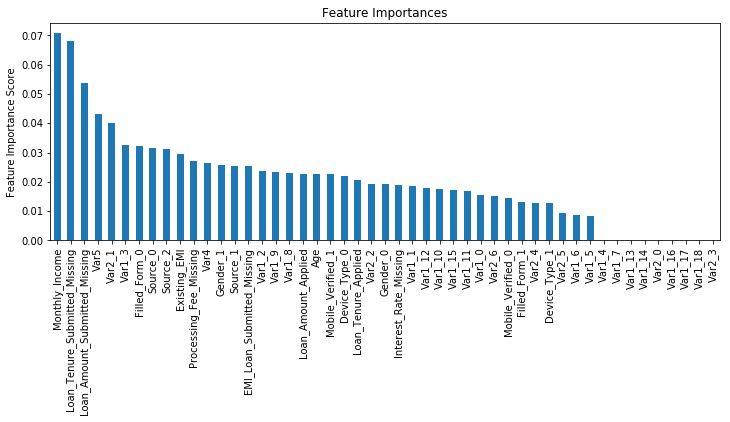

In [0]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=4,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

<font color=blue size=6> 
Step 6: Reducing Learning Rate
  <br></font>
  <font color=brown size=5> 
Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.884500


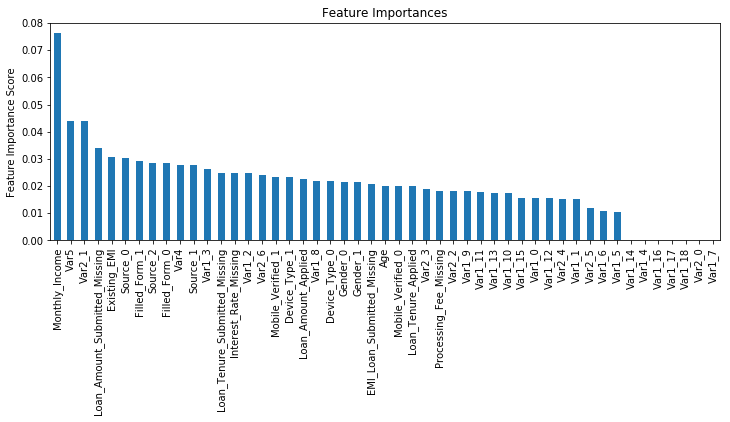

In [0]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=4,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)